<a href="https://colab.research.google.com/github/achalgarg14/session_4/blob/main/Session_4_Assignment_Code_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Attempt 2:
##Target:

* Reducing number of parameters to reach closer to 10k
* Add batch wise normalization for increasing model efficiency
* Introduce Dropouts to avoid overfitting
* Add GAP layer

##Results:

* Total Parameters: 11,944
* Best Training Accuracy: 99.31%
* Best Test Accuracy: 99.45%

##Analysis:

* Model learned well and can do better if pushed to more epochs. But with current limitations we can not go beyond 15 epochs.
* Batch Normalization has helped the model in learning even with reduced parameters.
* DropOut made the model resilient.
* Consistently Test Accuracy is higher than Train Accuracy, so model is not overfitting
* GAP layer (size of 4) has not reduced accuracy
* Last few epochs does not have consistent accuracy above 99.4%

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


#Data Checking

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train Data Stats]
Numpy Shape: (60000, 28, 28)
Tensor Shape: torch.Size([60000, 28, 28])
min: tensor(-0.4242)
max: tensor(2.8215)
mean: tensor(-0.0001)
std: tensor(1.0000)
var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor(4)


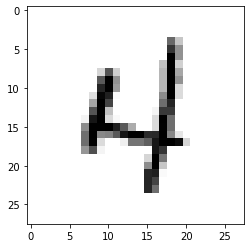

In [5]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train Data Stats]')
print('Numpy Shape:', train.train_data.cpu().numpy().shape)
print('Tensor Shape:', train.train_data.size())
print('min:', torch.min(train_data))
print('max:', torch.max(train_data))
print('mean:', torch.mean(train_data))
print('std:', torch.std(train_data))
print('var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
print(labels[0])
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

##Looking at bigger dataset
To understand data further for augmentation

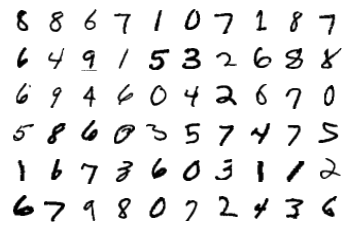

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Basic model to check everything is working

In [18]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26  RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24  RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12  RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value)            
        ) # output_size = 10  RF = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),   
            nn.Dropout(dropout_value)         
        ) # output_size = 8  RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)            
        ) # output_size = 6  RF = 18
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 4  RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1  RF = 28

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1  RF = 28


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [19]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 32, 10, 10]           4,608
      BatchNorm2d-11           [-1, 32, 10, 10]              64
             ReLU-12           [-1, 32, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [20]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

#Training and Testing of our model

In [21]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.06885773688554764 Batch_id=468 Accuracy=85.90: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]



Test set: Average loss: 0.0936, Accuracy: 9742/10000 (97.42%)

EPOCH: 2


Loss=0.10225800424814224 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]



Test set: Average loss: 0.0416, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.06927630305290222 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]



Test set: Average loss: 0.0319, Accuracy: 9914/10000 (99.14%)

EPOCH: 4


Loss=0.10572120547294617 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]



Test set: Average loss: 0.0324, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.016958994790911674 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]



Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.042329009622335434 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:13<00:00, 35.02it/s]



Test set: Average loss: 0.0294, Accuracy: 9905/10000 (99.05%)

EPOCH: 7


Loss=0.08269301801919937 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]



Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.018549880012869835 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]



Test set: Average loss: 0.0264, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.007067699450999498 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]



Test set: Average loss: 0.0252, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.008340343832969666 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]



Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.03924927860498428 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]



Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.011412504129111767 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]



Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.011205065064132214 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]



Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.033271726220846176 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]



Test set: Average loss: 0.0174, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Loss=0.008450113236904144 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]



Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)



# Plotting Accuracy and Loss Graphs



In [22]:
train_losses1 = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

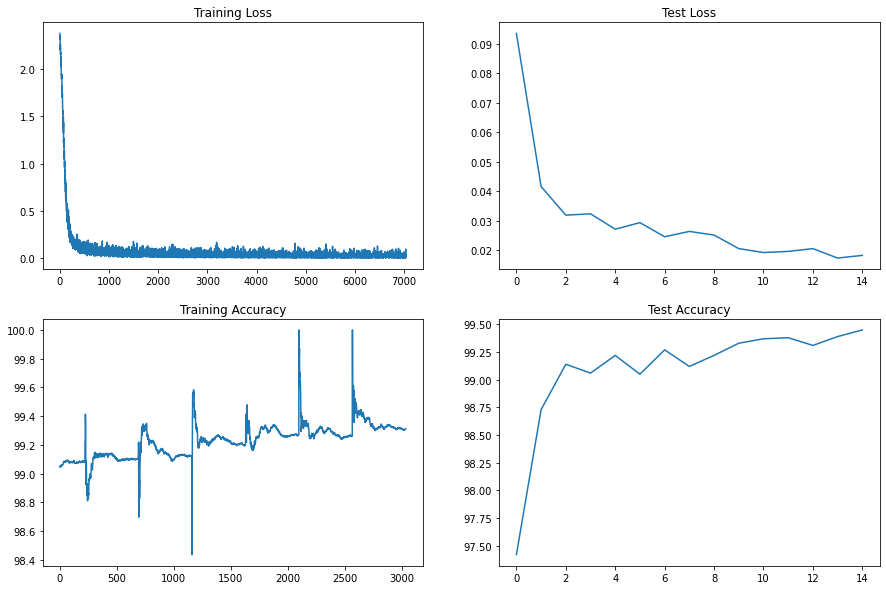

In [23]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")